In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
import string, re
import gc # garbage collector to manage RAM usage
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline

In [2]:
# Read the training data csv
tweets = pd.read_csv('train.csv')
tweets.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [3]:
# Rename columns to avoid clashes with the words in vocab later
tweets.rename(columns={'label':'Label', 'tweet':'Tweet'}, inplace=True)

# Drop column 'id'
tweets.drop(columns='id', inplace=True)

# Check distribution of class of tweets
tweets.Label.value_counts()

0    29720
1     2242
Name: Label, dtype: int64

In [4]:
# Split the original data into train and test data (80:20)
X_train, X_test, y_train, y_test = train_test_split(tweets['Tweet'], tweets['Label'], test_size=0.2, stratify=tweets['Label'], random_state=1)

# Combine the results into train and test dataframe
tweets_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
tweets_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

print(len(tweets_train))
print(len(tweets_test))
tweets_train.head()

25569
6393


,Tweet,Label
0,this is chess #mlittle801 #breezeslc #fitness ...,0
1,@user @user @user @user @user i bet thats wh...,0
2,happiness is @user so find your happiness tod...,0
3,@user &lt;3 &lt;3 listen to my most beautiful ...,0
4,free @user !! #jesuismilo !!,0


In [5]:
# Function to tokenise a tweet
def clean_tweet(tweet):
    """
    Tokenize tweets into words. Convert texts to lower case.
    Remove hashtags, punctuations, stopwords, website links, extra spaces, non-alphanumeric characters and 
    single character. Lemmatize texts.
    """
    twt_tokenizer = TweetTokenizer(strip_handles=True) # remove username handles
    tokens = [token for token in twt_tokenizer.tokenize(tweet)]
    
    # Combine stopwords and punctuation
    stops = stopwords.words("english") + list(string.punctuation)
    
    # Create lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    tokens_no_hashtag = [re.sub(r'#', '', token) for token in tokens]
    tokens_no_stopwords = [token.lower() for token in tokens_no_hashtag if token.lower() not in stops]
    tokens_no_url = [re.sub(r'http\S+', '', token) for token in tokens_no_stopwords]
    tokens_no_url = [re.sub(r'www\S+', '', token) for token in tokens_no_url]
    tokens_no_extra_space = [re.sub(r'\s\s+', '', token) for token in tokens_no_url]
    tokens_alnum = [token for token in tokens_no_extra_space if token.isalnum()]
    tokens_lemma = [lemmatizer.lemmatize(token) for token in tokens_alnum]
    tokens_final = [token for token in tokens_lemma if len(token) > 1]
    
    return tokens_final

In [6]:
# Apply the clean tweet function to the training set
tweets_train['Tweet'] = tweets_train['Tweet'].apply(clean_tweet)
tweets_train.head()

,Tweet,Label
0,"[chess, mlittle801, breezeslc, fitness, nofilt...",0
1,"[bet, thats, left, feeding, think, actually, b...",0
2,"[happiness, find, happiness, today, happiness,...",0
3,"[listen, beautiful, best, friend, singing, ama...",0
4,"[free, jesuismilo]",0


In [7]:
# Combine all the tweets into a single list
corpus = tweets_train['Tweet'].apply(lambda x:' '.join(x))

# Fit CountVectorizer
vectorizer = CountVectorizer()
X_train_wc = vectorizer.fit_transform(corpus)
X_train_wc

<25569x33097 sparse matrix of type '<class 'numpy.int64'>'
	with 185565 stored elements in Compressed Sparse Row format>

# Naive Bayes Model - Sklearn

In [8]:
# Convert y_train and y_test to array
y_train = np.array(tweets_train['Label'])
y_test = np.array(tweets_test['Label'])


In [9]:
# Create X_test_wc using sklearn CountVectorizer()
corpus = tweets_test['Tweet'].apply(clean_tweet).apply(lambda x:' '.join(x))
X_test_wc = vectorizer.transform(corpus)

In [10]:
# Ensure the shape of X, y in training and test set is correct
print("Shape of X_train: {}".format(X_train_wc.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of X_test: {}".format(X_test_wc.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of X_train: (25569, 33097)
Shape of y_train: (25569,)
Shape of X_test: (6393, 33097)
Shape of y_test: (6393,)


In [11]:
# Naive Bayes classifier
clf = MultinomialNB() # default smoothing parameter alpha=1

# Train the Naive Bayes classifier on the training set
clf.fit(X_train_wc, y_train)

# Get the score for test set
clf.score(X_test_wc, y_test)

0.9594869388393555

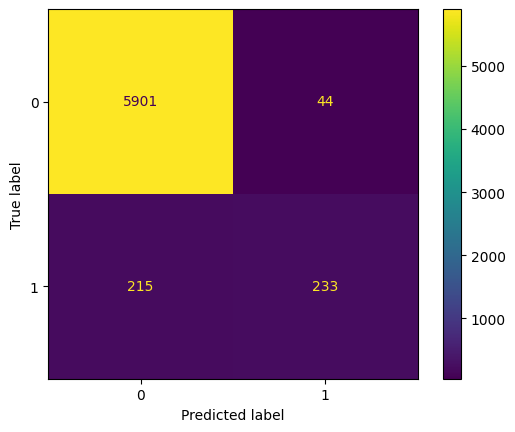

In [12]:
# Generate confusion matrix plot
y_pred = clf.predict(X_test_wc)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [13]:
def evaluate(confusion_matrix):
    """
    Evaluate classification performance metrics based on a confusion
    matrix.
    Args:
    confusion_matrix (list of lists): A 2x2 confusion matrix in the
    following format:
    [[true_negative, false_positive],
    [false_negative, true_positive]]
    Returns:
    dict: A dictionary containing precision, recall, sensitivity,
    specificity, accuracy, and F1-Score.
    """
    
    # Extract values from the confusion matrix
    true_negative, false_positive = confusion_matrix[0][0], confusion_matrix[0][1] 
    false_negative, true_positive = confusion_matrix[1][0], confusion_matrix[1][1]
    
    # Calculate the metrics
    
    # 1.) Precision
    precision = true_positive / (true_positive + false_positive)
    
    # 2.) Recall
    recall = true_positive / (true_positive + false_negative)
    
    # 3.) Sensitivity
    sensitivity = recall  # Sensitivity is the same as Recall
    
    # 4.) Specificity
    specificity = true_negative / (true_negative + false_positive)
    
    # 5.) Accuracy
    accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    
    # 6.) F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Create a dictionary containing the metrics
    metrics = {
        'Precision': precision,
        'Recall': recall,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'F1-Score': f1_score
    }

    return metrics

In [14]:
evaluate(cm)

{'Precision': 0.8411552346570397,
 'Recall': 0.5200892857142857,
 'Sensitivity': 0.5200892857142857,
 'Specificity': 0.9925988225399496,
 'Accuracy': 0.9594869388393555,
 'F1-Score': 0.6427586206896552}